In [1]:

import pandas as pd
import datetime
import numpy as np
from pathlib import Path
import sys
import os
import sys
sys.path.append("../../src/")
import micromet


In [3]:
import logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
logger = logging.getLogger(__name__)

In [9]:
#!/usr/bin/env python3
"""
Compile files by substring into one directory using *modified time* for versioning.

Rule per filename:
- Unique versions are identified by (mtime_ns, size).
- If only one unique pair exists, copy one file.
- If multiple unique pairs exist (i.e., EITHER mtime OR size differ), copy all versions,
  labeling sequentially: name_1.ext, name_2.ext, ... (sorted by mtime).

Usage:
  python compile_files.py --root /path/to/root --out /path/to/eddy --contains "21020_Flux_AmeriFluxFormat_"
"""

from __future__ import annotations
import argparse
import os
from pathlib import Path
from dataclasses import dataclass
from typing import Dict, List, Tuple
import shutil
import sys

@dataclass(frozen=True)
class FileInfo:
    path: Path
    size: int
    mtime_ns: int  # nanosecond resolution modified time

def _gather_files(root: Path, contains: str, case_sensitive: bool) -> List[Path]:
    files: List[Path] = []
    needle = contains if case_sensitive else contains.lower()
    for dirpath, _, filenames in os.walk(root):
        for fn in filenames:
            hay = fn if case_sensitive else fn.lower()
            if needle in hay:
                files.append(Path(dirpath) / fn)
    return files

def _to_fileinfo(paths: List[Path]) -> List[FileInfo]:
    out: List[FileInfo] = []
    for p in paths:
        try:
            st = p.stat()
            out.append(FileInfo(path=p, size=st.st_size, mtime_ns=st.st_mtime_ns))
        except FileNotFoundError:
            continue
    return out

def _group_by_filename(infos: List[FileInfo]) -> Dict[str, List[FileInfo]]:
    byname: Dict[str, List[FileInfo]] = {}
    for fi in infos:
        byname.setdefault(fi.path.name, []).append(fi)
    return byname

def _unique_by_mtime_size(items: List[FileInfo]) -> List[FileInfo]:
    """Deduplicate by the pair (mtime_ns, size)."""
    seen: set[Tuple[int, int]] = set()
    unique: List[FileInfo] = []
    for fi in items:
        key = (fi.mtime_ns, fi.size)
        if key not in seen:
            seen.add(key)
            unique.append(fi)
    return unique

def _ensure_outdir(p: Path):
    p.mkdir(parents=True, exist_ok=True)

def compile_files(
    root: Path,
    outdir: Path,
    contains: str,
    case_sensitive: bool = False,
    dry_run: bool = False,
    sequential_zero_pad: int = 1,
    debug: bool = False,
) -> None:
    _ensure_outdir(outdir)

    paths = _gather_files(root, contains, case_sensitive)
    infos = _to_fileinfo(paths)
    groups = _group_by_filename(infos)

    copied = 0
    labeled = 0
    skipped = 0

    if debug:
        print(f"Matched {len(infos)} files total in {len(groups)} filename group(s).")

    for filename, items in sorted(groups.items()):
        uniques = _unique_by_mtime_size(items)

        if debug:
            print(f"\n[GROUP] {filename} | {len(items)} found, {len(uniques)} unique by (mtime,size)")
            for fi in sorted(items, key=lambda x: (x.mtime_ns, x.size, str(x.path))):
                print(f"  {fi.path} | size={fi.size} | mtime_ns={fi.mtime_ns}")

        # Single unique (mtime,size) → copy once
        if len(uniques) == 1:
            src = uniques[0].path
            dst = outdir / filename

            # If an existing file with same name and same size already present, skip
            if dst.exists() and dst.stat().st_size == uniques[0].size:
                if debug:
                    print(f"  -> Exists with same size: SKIP {dst}")
                skipped += 1
                continue

            # If name collision with different size, append _1
            if dst.exists():
                stem, ext = Path(filename).stem, Path(filename).suffix
                dst = outdir / f"{stem}_1{ext}"

            if dry_run:
                print(f"[DRY-RUN] COPY {src} -> {dst}")
            else:
                shutil.copy2(src, dst)
            copied += 1
            if debug:
                print(f"  -> Copied once to {dst}")

        else:
            # Multiple unique versions → copy all, sequentially labeled by ascending mtime
            uniques_sorted = sorted(uniques, key=lambda fi: fi.mtime_ns)
            stem, ext = Path(filename).stem, Path(filename).suffix
            idx = 1
            for fi in uniques_sorted:
                suffix = f"_{str(idx).zfill(sequential_zero_pad)}"
                dst = outdir / f"{stem}{suffix}{ext}"
                # Avoid accidental overwrite if rerun
                while dst.exists():
                    idx += 1
                    suffix = f"_{str(idx).zfill(sequential_zero_pad)}"
                    dst = outdir / f"{stem}{suffix}{ext}"
                if dry_run:
                    print(f"[DRY-RUN] COPY {fi.path} -> {dst}")
                else:
                    shutil.copy2(fi.path, dst)
                labeled += 1
                if debug:
                    print(f"  -> Labeled copy: {dst}")
                idx += 1

    print(f"Done. Copied (single): {copied}, Labeled (sequential): {labeled}, Skipped duplicates: {skipped}")




In [6]:
from pathlib import Path, PurePath
import os, time
p = Path(r"G:\Shared drives\UGS_Flux\Data_Downloads\Escalante\e20250709\21021_Flux_AmeriFluxFormat_2.dat")
s = p.stat()
print("size:", s.st_size)
ctime = getattr(s, "st_birthtime", s.st_birthtime)  # see OS caveat
print("ctime:", ctime, time.ctime(ctime))
os.path.getmtime(p)

size: 134514
ctime: 1752181701.529 Thu Jul 10 15:08:21 2025


1748323800.0

In [10]:
root = Path("G:/Shared drives/UGS_Flux/Data_Downloads/")

site_folders = {
    "US-UTD": "Dugout_Ranch",
    "US-UTB": "BSF",
    "US-UTJ": "Bluff",
    "US-UTW": "Wellington",
    "US-UTE": "Escalante",
    "US-UTM": "Matheson",
    "US-UTP": "Phrag",
    "US-CdM": "Cedar_mesa",
    "US-UTV": "Desert_View_Myton",
    "US-UTN": "Juab",
    "US-UTG": "Green_River",
}

root_main = Path("G:/Shared drives/UGS_Flux/Data_Downloads/")


case_sensitive = False
dryrun = False
use_mtime = False
sequential_zero_pad = 2

data = {}
for stationid, folder in site_folders.items():
    for datatype in ["Statistics_Ameriflux", "AmeriFluxFormat", "Flux_CSFormat", "Flux_Notes", "Config_Setting_Notes","System_Operatn_Notes"]:
        print(f"Processing {stationid} - {datatype}")
        p = root_main / stationid / datatype
        p.mkdir(parents=True, exist_ok=True)  # creates it (and parents) if missing
        
        compile_files(
            root_main / folder,
            p,
            datatype,
            case_sensitive,
            dryrun,
            use_mtime,
            sequential_zero_pad,
        )


Processing US-UTD - Statistics_Ameriflux
Matched 128 files total in 72 filename group(s).

[GROUP] 21031_Statistics_AmeriFlux0.dat | 1 found, 1 unique by (mtime,size)
  G:\Shared drives\UGS_Flux\Data_Downloads\Dugout_Ranch\d20231026_met\21031_Statistics_AmeriFlux0.dat | size=17421 | mtime_ns=1685032210000000000
  -> Copied once to G:\Shared drives\UGS_Flux\Data_Downloads\US-UTD\Statistics_Ameriflux\21031_Statistics_AmeriFlux0.dat

[GROUP] 21031_Statistics_AmeriFlux1.dat | 1 found, 1 unique by (mtime,size)
  G:\Shared drives\UGS_Flux\Data_Downloads\Dugout_Ranch\d20231026_met\21031_Statistics_AmeriFlux1.dat | size=99926 | mtime_ns=1685406610000000000
  -> Copied once to G:\Shared drives\UGS_Flux\Data_Downloads\US-UTD\Statistics_Ameriflux\21031_Statistics_AmeriFlux1.dat

[GROUP] 21031_Statistics_AmeriFlux10.dat | 1 found, 1 unique by (mtime,size)
  G:\Shared drives\UGS_Flux\Data_Downloads\Dugout_Ranch\met_20240604\21031_Statistics_AmeriFlux10.dat | size=697323 | mtime_ns=17120394080000000

In [ ]:
root = Path("G:/Shared drives/UGS_Flux/Data_Downloads/")

site_folders = {
    "US-UTD": "Dugout_Ranch",
    "US-UTB": "BSF",
    "US-UTJ": "Bluff",
    "US-UTW": "Wellington",
    "US-UTE": "Escalante",
    "US-UTM": "Matheson",
    "US-UTP": "Phrag",
    "US-CdM": "Cedar_mesa",
    "US-UTV": "Desert_View_Myton",
    "US-UTN": "Juab",
    "US-UTG": "Green_River",
}
data = {}
for stationid, folder in site_folders.items():
    for datatype in ["met", "eddy"]:
        if datatype == "met":
            station_table_str = "Statistics_Ameriflux"
        else:
            station_table_str = "AmeriFluxFormat"
        
        micromet.fix_all_in_parent(root,"21031_Statistics_AmeriFlux*.dat")  # recurse=True if sub-sub-folders exist


✔ All possible files have been checked.


defaultdict(list,
            {'21031_Statistics_AmeriFlux_5.dat': [WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/m20240415/21031_Statistics_AmeriFlux_5.dat'),
              WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/m20240604/21031_Statistics_AmeriFlux_5.dat'),
              WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/Met/21031_Statistics_AmeriFlux_5.dat')],
             '21031_Statistics_AmeriFlux_6.dat': [WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/m20240415/21031_Statistics_AmeriFlux_6.dat'),
              WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/m20240604/21031_Statistics_AmeriFlux_6.dat'),
              WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/Met/21031_Statistics_AmeriFlux_6.dat')],
             '21031_Statistics_AmeriFlux_7.dat': [WindowsPath('G:/Shared drives/UGS_Flux/Data_Downloads/Dugout_Ranch/m20240415/21031_Statistics_AmeriFlux_7.da

In [13]:
root = Path(r"G:\Shared drives\UGS_Flux\Data_Downloads")  # <── your top-level directory here
proc = micromet.AmerifluxDataProcessor(logger=logger)


datatype = "met"  # or "met"

site_folders = {
    #"US-UTD": "Dugout_Ranch",
    #"US-UTB": "BSF",
    #"US-UTJ": "Bluff",
    #"US-UTW": "Wellington",
    #"US-UTE": "Escalante",
    "US-UTM": "Matheson",
    #"US-UTP": "Phrag",
    #"US-CdM": "Cedar_mesa",
    #"US-UTV": "Desert_View_Myton",
    #"US-UTN": "Juab",
    #"US-UTG": "Green_River",
}
data = {}
for stationid, folder in site_folders.items():
    if datatype == "met":
        search_str = f"*Statistics_Ameriflux*.dat"
    else:
        search_str = f"*AmeriFluxFormat_*.dat"
    df = proc.raw_file_compile(stationid, root / folder, search_str)
    df.to_parquet(root / f"{stationid}_{datatype}_{df['file_no'].min()}_{df['file_no'].max()}_data.parquet",)

2025-06-30 13:17:50,186 - INFO - Compiling data from G:\Shared drives\UGS_Flux\Data_Downloads\Matheson
2025-06-30 13:17:50,248 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\m20231114\21024_Statistics_AmeriFlux_5.dat


RuntimeError: Header line not recognized: ['NAN', 'NAN', '-0.007947828', '3.134989', '11.58587', '0', '-0.106459', '0', '0.04575901', '0.1483306', '0.2090305', '28.6028', '25.07263', '0', '0', '1.140434', '19.74359', '0', '0.0406289', '3.616979', '11.89953', '0', '0.142124', '7.804804', '9.249237', '0.0546796', '0.2057532', '11.24153', '9.790527', '0.0993573', '0.2223839', '12.24285', '10.35925', '0.2531899', '0.4122892', '26.70557', '11.38085', '0.6236694', '0.5228981', '37.60917', '11.20172', '0.8655991', '0.5415203', '39.02299', '10.69015', '0.8393306', '0.4674377', '31.94908', '10.73443', '1.274525', '0', '0.9568054', '21.19155', '0', '0', '1.786998', '13.32614', '0', '0.1034809', '6.022794', '9.141632', '0', '0.2011652', '10.97281', '9.551696', '0.1807974', '0.2588822', '14.59013', '10.07412', '0.2742372', '0.3823725', '24.0576', '10.40325', '0.5023172', '0.4388724', '29.17446', '10.49136', '0.5903687', '0.4462965', '29.88347', '10.71228', '0.9060248', '0', '0', '0', '0', '2.953411', '188.1799', '255.8741', '25.83333', '0', '0']

In [ ]:
root = Path(r"G:/Shared drives/UGS_Flux/Data_Downloads/Matheson/e20250127/")  # <── your top-level directory here
proc = micromet.AmerifluxDataProcessor(logger=logger)

datatype = "eddy"  # or "met"
data = {}

search_str = f"*AmeriFluxFormat_*.dat"
df = proc.raw_file_compile("US-UTM", root, search_str)
df.to_parquet(root / f"{stationid}_{datatype}_onelines_data.parquet",)

2025-06-30 13:52:17,263 - INFO - Compiling data from G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127
2025-06-30 13:52:17,310 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_1003.dat
2025-06-30 13:52:17,341 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_1005.dat
2025-06-30 13:52:17,362 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_1004.dat
2025-06-30 13:52:17,382 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_100.dat
2025-06-30 13:52:17,399 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_1002.dat
2025-06-30 13:52:17,415 - INFO - Processing file: G:\Shared drives\UGS_Flux\Data_Downloads\Matheson\e20250127\21022_Flux_AmeriFluxFormat_10.dat
2025-06-30 13:

In [ ]:
root = Path(r"C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files") 
micromet.fix_all_in_parent(root,"AmeriFluxFormat_*.dat")  # recurse=True if sub-sub-folders exist
proc = micromet.AmerifluxDataProcessor(logger=logger)

datatype = "eddy"  # or "met"
data = {}

search_str = f"*AmeriFluxFormat_*.dat"
df2 = proc.raw_file_compile("US-UTM", root, search_str)
df2.to_parquet(root / f"{stationid}_{datatype}_.parquet",)



2025-06-30 14:05:28,092 - INFO - Compiling data from C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files
2025-06-30 14:05:28,095 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_10 (2).dat
2025-06-30 14:05:28,110 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_10.dat
2025-06-30 14:05:28,115 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_11.dat
2025-06-30 14:05:28,126 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_12.dat
2025-06-30 14:05:28,139 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_13.dat
2025-06-30 14:05:28,151 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21022_Flux_AmeriFluxFormat_14.dat
2025-06-30 14:05:28,156 - INFO - 


✔ All possible files have been checked.


2025-06-30 14:05:28,309 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_1.dat
2025-06-30 14:05:28,319 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_10.dat
2025-06-30 14:05:28,336 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_11.dat
2025-06-30 14:05:28,352 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_12.dat
2025-06-30 14:05:28,363 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_13.dat
2025-06-30 14:05:28,384 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_14.dat
2025-06-30 14:05:28,393 - INFO - Processing file: C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Eddy_Files\21029_Flux_AmeriFluxFormat_15.dat
2025-06

In [24]:
eddy_data = pd.concat([df,df2],axis=0)

In [33]:
eddy_data
# Convert numbers to strings, get their lengths, then count occurrences of each length
length_counts = eddy_data['TIMESTAMP_END'].astype(str).str.len().value_counts().sort_index()

print(length_counts)
eddy_data.to_parquet(root / f"{stationid}_{datatype}_alldata.parquet",)

TIMESTAMP_END
12    18420
Name: count, dtype: int64


In [ ]:
df3 = pd.read_csv(r"C:\Users\paulinkenbrandt\Desktop\Flux\Matheson\Matheson Wetlands_Flux_AmeriFluxFormat (2).dat", na_values=['NAN'])

TIMESTAMP  RECORD  TIMESTAMP_START  TIMESTAMP_END       CO2  \
0      2022-10-26 15:30:00       1     202210261500   202210261530  414.0292   
1      2022-10-26 16:00:00       2     202210261530   202210261600  413.9501   
2      2022-10-26 16:30:00       3     202210261600   202210261630  413.5509   
3      2022-10-26 17:00:00       4     202210261630   202210261700  412.5099   
4      2022-10-26 17:30:00       5     202210261700   202210261730  415.6979   
...                    ...     ...              ...            ...       ...   
21499  2024-08-10 18:30:00    4138     202408101800   202408101830  411.7223   
21500  2024-08-10 19:00:00    4139     202408101830   202408101900  411.0712   
21501  2024-08-10 19:30:00    4140     202408101900   202408101930  416.0096   
21502  2024-08-10 20:00:00    4141     202408101930   202408102000  416.0174   
21503  2024-08-10 20:30:00    4142     202408102000   202408102030  421.9770   

       CO2_SIGMA        H2O  H2O_SIGMA        FC  FC_SSITC_TEST  ...  \
0       0.322101   9.419745   0.186403  3.358857            1.0  ...   
1       0.296363   9.417489   0.179287  1.980242            1.0  ...   
2       0.426511   9.342575   0.105641  1.625808            4.0  ...   
3       0.541630   9.403389   0.187825  0.552079            8.0  ...   
4       5.603356   9.722460   0.094429  2.767656            9.0  ...   
...          ...        ...        ...       ...            ...  ...   
21499   0.517100  17.055970   0.480114  3.802385            3.0  ...   
21500   0.558225  18.269070   0.454573  3.993999            3.0  ...   
21501  14.459760  18.162030   1.160824  2.486727            2.0  ...   
21502   8.496524  17.885380   0.948971  0.330693            9.0  ...   
21503   6.392967  17.029650   0.458810  1.567172            9.0  ...   

       TS_4_8_1  EC_4_8_1  EC_4_9_1  SWC_4_9_1  K_4_9_1  TS_4_9_1  TS_2_1_1  \
0           NaN       NaN       NaN        NaN      NaN       NaN       NaN   
1           NaN       NaN       NaN        NaN      NaN       NaN       NaN   
2           NaN       NaN       NaN        NaN      NaN       NaN       NaN   
3           NaN       NaN       NaN        NaN      NaN       NaN       NaN   
4           NaN       NaN       NaN        NaN      NaN       NaN       NaN   
...         ...       ...       ...        ...      ...       ...       ...   
21499       NaN       NaN       NaN        NaN      NaN       NaN       NaN   
21500       NaN       NaN       NaN        NaN      NaN       NaN       NaN   
21501       NaN       NaN       NaN        NaN      NaN       NaN       NaN   
21502       NaN       NaN       NaN        NaN      NaN       NaN       NaN   
21503       NaN       NaN       NaN        NaN      NaN       NaN       NaN   

       SWC_2_1_1  TA_1_4_1  Battery_Voltage  
0            NaN       NaN              NaN  
1            NaN       NaN              NaN  
2            NaN       NaN              NaN  
3            NaN       NaN              NaN  
4            NaN       NaN              NaN  
...          ...       ...              ...  
21499   20.16303 -87.27771              NaN  
21500   20.14604 -87.28137              NaN  
21501   20.13653 -87.28614              NaN  
21502   20.07344 -87.28927              NaN  
21503   20.08137 -87.30105              NaN  

[21504 rows x 212 columns]

In [36]:
eddy_data = eddy_data.sort_values(['TIMESTAMP_START'])


import plotly.graph_objects as go

# ----- assume `hourly` already exists from the resample/agg step -----
# If not, run the block from the previous answer first.

fig = go.Figure()

# 1) add the “central-tendency” curves
fig.add_scatter(
    x=pd.to_datetime(eddy_data['TIMESTAMP_START'],format="%Y%m%d%H%M"), y=eddy_data['CO2'],
    mode="lines", name="mean"
)

In [12]:
root = Path(r"G:\Shared drives\UGS_Flux\Data_Downloads")  # <── your top-level directory here
for file in root.glob("*.parquet"):
    print(file)

G:\Shared drives\UGS_Flux\Data_Downloads\US-UTD_eddy_0_23_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTB_eddy_0_45_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTJ_eddy_1_20_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTW_eddy_0_50_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTE_eddy_0_12_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTP_eddy_0_9999_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-CdM_eddy_0_19_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTV_eddy_0_29_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTG_eddy_0_7_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTD_met_5_9999_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTJ_met_0_9999_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTE_met_0_9999_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-UTP_met_0_9999_data.parquet
G:\Shared drives\UGS_Flux\Data_Downloads\US-CdM_met_0_9999_data.parquet


In [ ]:
pd.read_parquet(r"G:\Shared drives\UGS_Flux\Data_Downloads\US-UTM_eddy_0_23_data.parquet")

TIMESTAMP_START  TIMESTAMP_END       ALB      NETRAD       SW_IN  \
0         202310260830   202310260900  24.16074  -10.711610   79.326940   
1         202310260900   202310260930  24.84335  159.641800  314.583200   
2         202310260930   202310261000  23.70288         NaN         NaN   
3         202310261000   202310261030  22.87897    9.198333  126.035300   
4         202310261030   202310261100  22.09374   38.510250  159.753600   
...                ...            ...       ...         ...         ...   
68088     202412272100   202412272130   0.00000  -42.763110   -0.521222   
68089     202412272130   202412272200   0.00000  -68.832440   -0.732000   
68090     202412272200   202412272230   0.00000  -66.212910   -0.762417   
68091     202412272230   202412272300   0.00000  -62.420000   -0.678139   
68092     202412272300   202412272330   0.00000  -61.066190   -0.681944   

          SW_OUT     LW_IN    LW_OUT   T_CANOPY  T_SI111_body  ...  \
0      20.174640  293.1630  363.0269   7.861156     11.391150  ...   
1      81.059340  311.3093  385.1913  12.585570     14.378940  ...   
2            NaN       NaN       NaN  12.578060     15.966210  ...   
3      29.085550  289.3351  377.0864  10.987410     14.562030  ...   
4      37.294300  295.2404  379.1895  11.316540     14.450050  ...   
...          ...       ...       ...        ...           ...  ...   
68088  -0.115194  271.9177  314.2747  -1.527029      1.712341  ...   
68089  -0.022500  237.7209  305.8438  -3.865474      1.041148  ...   
68090  -0.090222  235.0934  300.6341  -5.049711     -0.354648  ...   
68091  -0.089917  238.9159  300.7477  -4.880823     -0.904645  ...   
68092  -0.107111  242.4824  302.9737  -4.290049     -0.364269  ...   

       LWmV_1_1_1  LWMDry_1_1_1  LWMCon_1_1_1  LWMWet_1_1_1  LWmV_1_1_2  \
0        262.5575         100.0           0.0           0.0    262.5203   
1        261.1911         100.0           0.0           0.0    261.1948   
2        261.5587         100.0           0.0           0.0    261.3105   
3        262.0614         100.0           0.0           0.0    261.7790   
4        262.0297         100.0           0.0           0.0    261.6741   
...           ...           ...           ...           ...         ...   
68088    268.7204         100.0           0.0           0.0    268.0498   
68089    269.1631         100.0           0.0           0.0    268.1617   
68090    269.7886         100.0           0.0           0.0    267.5774   
68091    269.9974         100.0           0.0           0.0    271.4360   
68092    269.7996         100.0           0.0           0.0    268.7011   

       LWMDry_1_1_2  LWMCon_1_1_2  LWMWet_1_1_2  file_no  datalogger_no  
0             100.0           0.0           0.0        5          21031  
1             100.0           0.0           0.0        5          21031  
2             100.0           0.0           0.0        5          21031  
3             100.0           0.0           0.0        5          21031  
4             100.0           0.0           0.0        5          21031  
...             ...           ...           ...      ...            ...  
68088         100.0           0.0           0.0     9999           9999  
68089         100.0           0.0           0.0     9999           9999  
68090         100.0           0.0           0.0     9999           9999  
68091         100.0           0.0           0.0     9999           9999  
68092         100.0           0.0           0.0     9999           9999  

[68093 rows x 59 columns]

In [7]:
df = pd.read_parquet(root / "US-UTD_met_5_9999_data.parquet")

am_data = micromet.Reformatter(drop_soil=False,
                                logger=logger,
                                )
#raw_data = raw_data.drop([0], axis=0)
am_df = am_data.prepare(df)
am_df['datalogger_no'] = 21031
am_df

2025-06-30 12:30:14,685 - INFO - Starting reformat (68093 rows)
2025-06-30 12:30:15,686 - INFO - Done; final shape: (34552, 59)


TIMESTAMP_START  TIMESTAMP_END         ALB     NETRAD  \
datetime_start                                                               
2023-05-24 15:30:00     202305241530   202305241600 -9999.00000 -9999.0000   
2023-05-24 16:00:00     202305241600   202305241630 -9999.00000 -9999.0000   
2023-05-24 16:30:00     202305241630   202305241700 -9999.00000 -9999.0000   
2023-05-24 17:00:00     202305241700   202305241730     7.80607 -9999.0000   
2023-05-24 17:30:00     202305241730   202305241800    24.82800   252.0812   
...                              ...            ...         ...        ...   
2025-05-13 09:00:00     202505130900   202505130930    23.49375   446.7189   
2025-05-13 09:30:00     202505130930   202505131000    22.89209   509.1336   
2025-05-13 10:00:00     202505131000   202505131030    22.35525   563.4611   
2025-05-13 10:30:00     202505131030   202505131100    21.78752   605.3776   
2025-05-13 11:00:00     202505131100   202505131130    21.38042   637.4340   

                         SW_IN     SW_OUT      LW_IN     LW_OUT    T_CANOPY  \
datetime_start                                                                
2023-05-24 15:30:00 -9999.0000 -9999.0000 -9999.0000 -9999.0000 -9999.00000   
2023-05-24 16:00:00 -9999.0000 -9999.0000 -9999.0000 -9999.0000 -9999.00000   
2023-05-24 16:30:00 -9999.0000 -9999.0000 -9999.0000 -9999.0000 -9999.00000   
2023-05-24 17:00:00 -9999.0000 -9999.0000 -9999.0000 -9999.0000 -9999.00000   
2023-05-24 17:30:00   500.1144   124.7287   314.2957   437.6002    23.80682   
...                        ...        ...        ...        ...         ...   
2025-05-13 09:00:00   761.8327   178.9415   289.9461   426.1184    19.63299   
2025-05-13 09:30:00   835.5638   191.2458   294.1239   429.3082    20.33200   
2025-05-13 10:00:00   901.9198   201.5875   297.2929   434.1642    21.22629   
2025-05-13 10:30:00   951.9034   207.3797   300.8767   440.0228    22.18126   
2025-05-13 11:00:00   990.0894   211.6744   301.4280   442.4090    22.66282   

                     T_SI111_body  ...  LWmV_1_1_1  LWMDry_1_1_1  \
datetime_start                     ...                             
2023-05-24 15:30:00     -78.72036  ...  -1315.1310      43.88889   
2023-05-24 16:00:00     -78.50776  ...   -110.6724     100.00000   
2023-05-24 16:30:00     -78.49310  ...    256.0321     100.00000   
2023-05-24 17:00:00      18.83090  ...    255.9044     100.00000   
2023-05-24 17:30:00      26.97647  ...    254.9888     100.00000   
...                           ...  ...         ...           ...   
2025-05-13 09:00:00      21.44107  ...    258.6791     100.00000   
2025-05-13 09:30:00      21.40081  ...    258.6787     100.00000   
2025-05-13 10:00:00      21.79152  ...    258.4643     100.00000   
2025-05-13 10:30:00      22.40828  ...    258.2034     100.00000   
2025-05-13 11:00:00      22.57568  ...    258.0860     100.00000   

                     LWMCon_1_1_1  LWMWet_1_1_1  LWmV_1_1_2  LWMDry_1_1_2  \
datetime_start                                                              
2023-05-24 15:30:00           0.0           0.0  -1816.1490      43.88889   
2023-05-24 16:00:00           0.0           0.0   -222.0543     100.00000   
2023-05-24 16:30:00           0.0           0.0    257.6569     100.00000   
2023-05-24 17:00:00           0.0           0.0    257.9362     100.00000   
2023-05-24 17:30:00           0.0           0.0    257.9271     100.00000   
...                           ...           ...         ...           ...   
2025-05-13 09:00:00           0.0           0.0    258.3070     100.00000   
2025-05-13 09:30:00           0.0           0.0    258.4439     100.00000   
2025-05-13 10:00:00           0.0           0.0    258.7210     100.00000   
2025-05-13 10:30:00           0.0           0.0    258.9913     100.00000   
2025-05-13 11:00:00           0.0           0.0    258.5698     100.00000   

                     LWMCon_1_1_2  LWMWet_1_1_2  file_no  datalogger_no  
datetime_start   

<Axes: xlabel='datetime_start'>

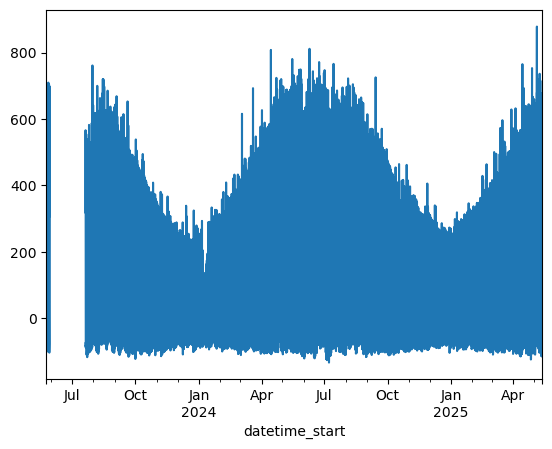

In [8]:
am_df['NETRAD'].replace(-9999,np.nan).plot()

In [ ]:
# Process data for all stations
site_folders = {#'US-UTD':'Dugout_Ranch',
                'US-UTB':'BSF',
                'US-UTJ':'Bluff',
                'US-UTW':'Wellington',
                'US-UTE':'Escalante',
                'US-UTM':'Matheson',
                'US-UTP':'Phrag',
                'US-CdM':'Cedar_Mesa',
                'US-UTV':'Desert_View_Myton',
                'US-UTL':'Pelican_Lake',
                'US-UTG':'Green_River',
                }


loggertype = 'eddy'
station = 'US-UTE'
station_id = manager.get_station_id(station)
manager = micromet.StationDataProcessor(config=config, 
                                        engine=engine)
last_date = manager.get_max_date(station)
raw_data, pack_size, status_code = manager.download_from_station(station,
                                                                 loggertype=loggertype,
                                                                 p1=f"{pd.to_datetime(last_date, format="%Y%m%d%H%M"):%Y-%m-%d %H:%M}",
                                                                )

manager.process_station_data(site_folders,
                             config_path = "../../src/micromet/data/reformatter_vars.yml",
                             var_limits_csv = "../../src/micromet/data/extreme_values.csv",       
                             )